# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(1234)

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (16, 4)})
import seaborn as sns

sns.set()

# 12.0 Introduction

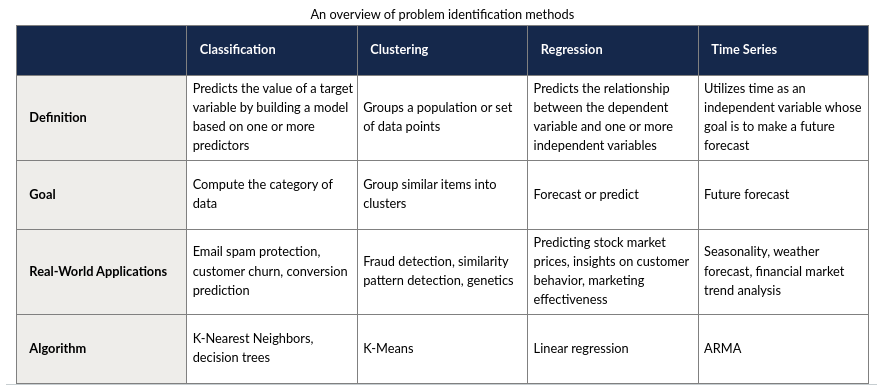

# 12.1 Introduction to Classification

## Classification vs. Regression

Regression - given set of features, predict real-valued outcome

Classification - given set of features, predict what class a sample belongs to

In [3]:
df = pd.read_csv("./data/pay_status.csv")
df

Income     Debt       Status
0    6552.53  1170.93  Did Not Pay
1    7247.80   570.94  Did Not Pay
2    8074.38   422.67  Did Not Pay
3    5776.60   872.42  Did Not Pay
4    6297.35   887.56  Did Not Pay
..       ...      ...          ...
220  1524.25  1071.41         Paid
221  2712.88  1261.57         Paid
222  2901.38  1228.07         Paid
223  1805.46  1214.41         Paid
224  2106.99  1133.36         Paid

[225 rows x 3 columns]

In [4]:
px.scatter(df, x="Income", y="Debt", color="Status")

# Overview

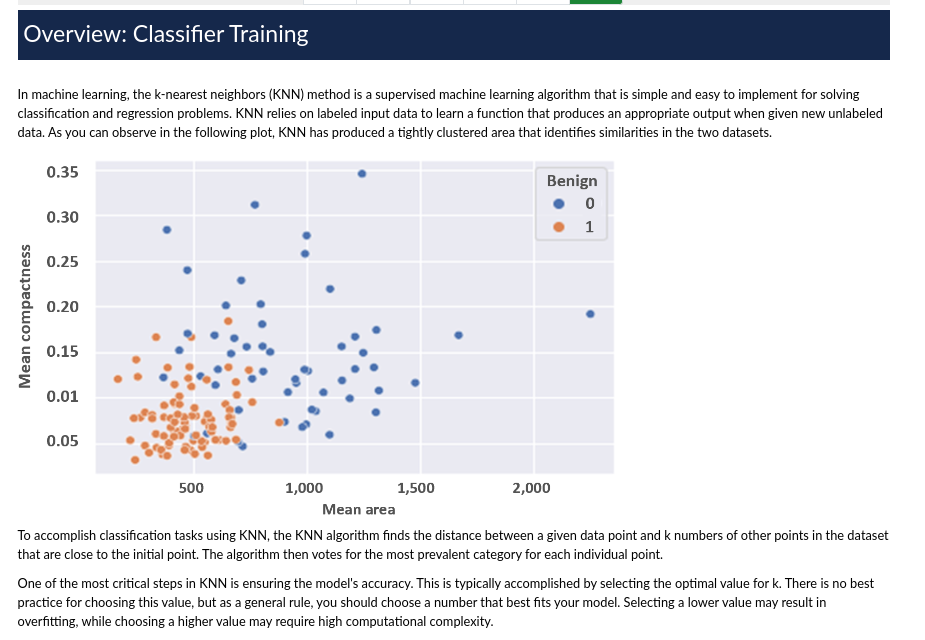

# 12.2 Nearest Neighbors in scikit learn

Easiest question - for a given query point, what point in training set is closest?

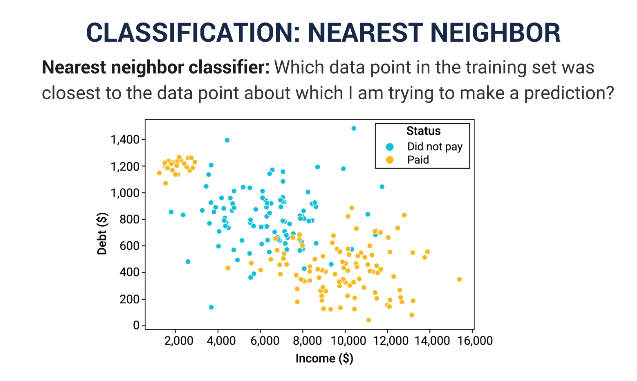

In [5]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(df[["Income", "Debt"]], df["Status"])

KNeighborsClassifier(n_neighbors=1)

In [6]:
model.predict([[13000, 400]])

array(['Paid'], dtype=object)

What did the model learn?

Model appears too sensitive, decision boundary is very complicated

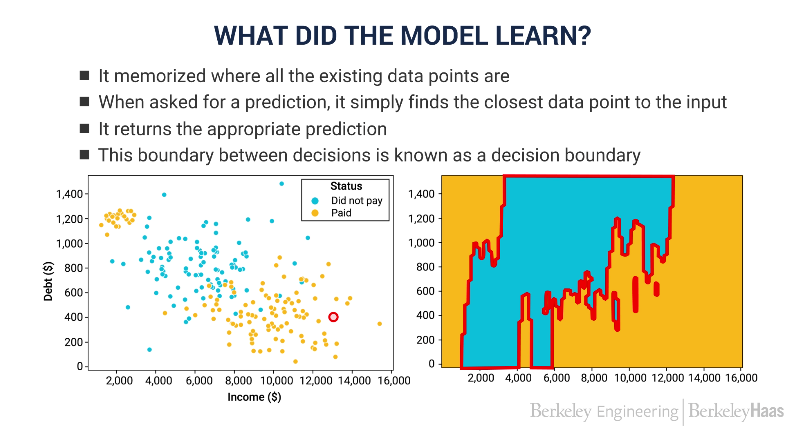

# 12.3 k-Nearest Neighbors

From prior lecture, k = 1 seemed too sensitive. Try a bigger value

In [7]:
X, y = df[["Income", "Debt"]].to_numpy(), df["Status"]

In [8]:
model_03 = KNeighborsClassifier(n_neighbors=3).fit(X, y)
model_50 = KNeighborsClassifier(n_neighbors=50).fit(X, y)

Text(0.5, 1.0, 'n_neighbors = 50')

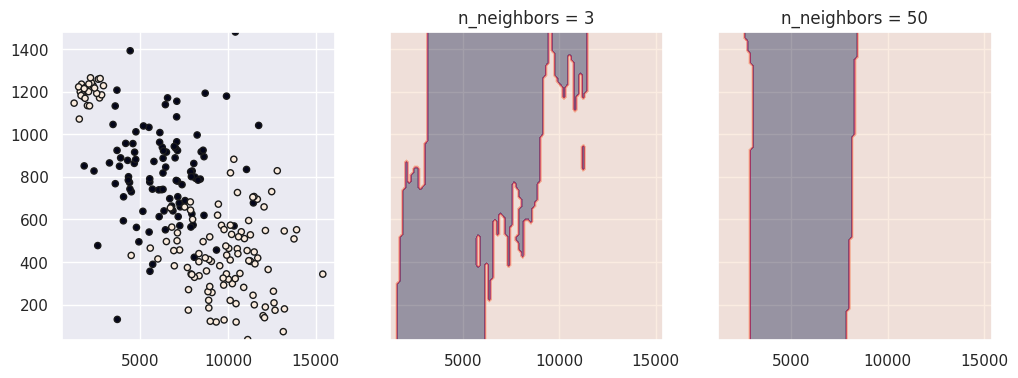

In [9]:
f, ax = plt.subplots(1, 3, sharex="col", sharey="row", figsize=(12, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=y == "Paid", s=20, edgecolor="k")

DecisionBoundaryDisplay.from_estimator(
    model_03, X, alpha=0.4, response_method="predict", ax=ax[1]
)
ax[1].set_title("n_neighbors = 3")

DecisionBoundaryDisplay.from_estimator(
    model_50, X, alpha=0.4, response_method="predict", ax=ax[2]
)
ax[2].set_title("n_neighbors = 50")

After trying many values, observe trend:
- As k gets bigger, decision boundary gets smoother

Tradeoffs:
- Small k - model is too complex, variance high
- Large k - model is too simple

Therefore k is a complexity hyperparameter, where complexity ~ 1/k i.e. inversely proportional to k
- Max complexity: k = 1
- Min complexity: k = n = number of points in data set

Is this counterintuitive?
- Consider that for k = n, choose the most common label
- And for k = 1, label every point

# 12.4 Choosing K

k is a hyperparameter, like alpha from ridge regression. So there should be an applicable error vs. complexity to make.

For x axis, use -k, since bigger k = smaller -k -> less complex

For y axis, consider misclassification rate = 1.0 - accuracy

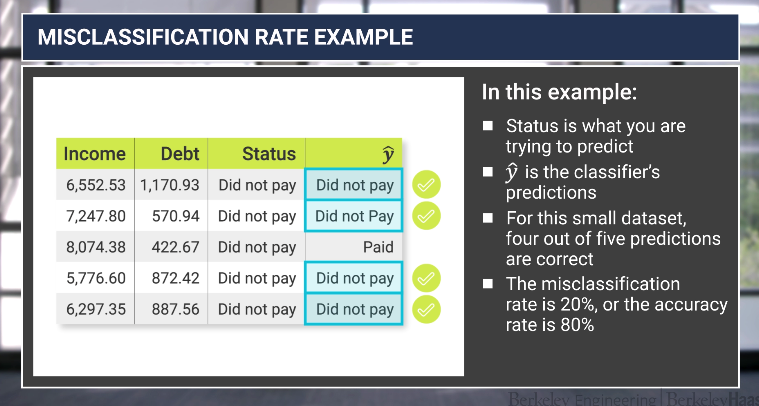

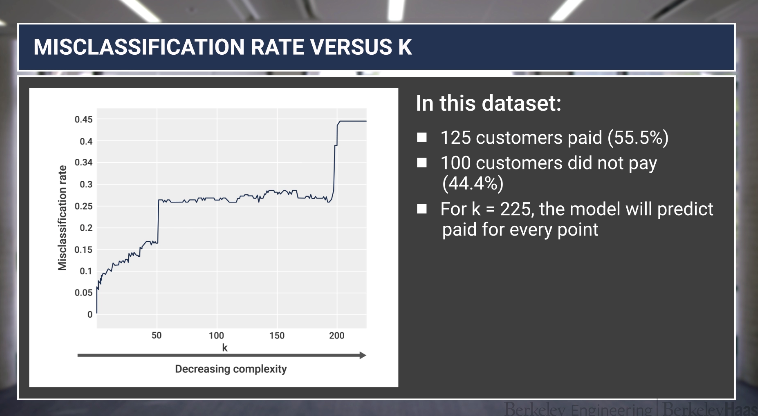

In [10]:
X, y = df[["Income", "Debt"]].to_numpy(), df["Status"]


def get_misclassication_rate_for_k(k):
    return 1.0 - accuracy_score(
        y, KNeighborsClassifier(n_neighbors=k).fit(X, y).predict(X)
    )

In [11]:
get_misclassication_rate_for_k(5)

0.09333333333333338

In [12]:
ks = range(1, len(df))
errors = [get_misclassication_rate_for_k(k) for k in ks]
errors_and_ks = pd.DataFrame({"k": ks, "Misclassification Rate": errors}, index=ks)
errors_and_ks

k  Misclassification Rate
1      1                0.000000
2      2                0.062222
3      3                0.084444
4      4                0.075556
5      5                0.093333
..   ...                     ...
220  220                0.444444
221  221                0.444444
222  222                0.444444
223  223                0.444444
224  224                0.444444

[224 rows x 2 columns]

## Plot vs. k

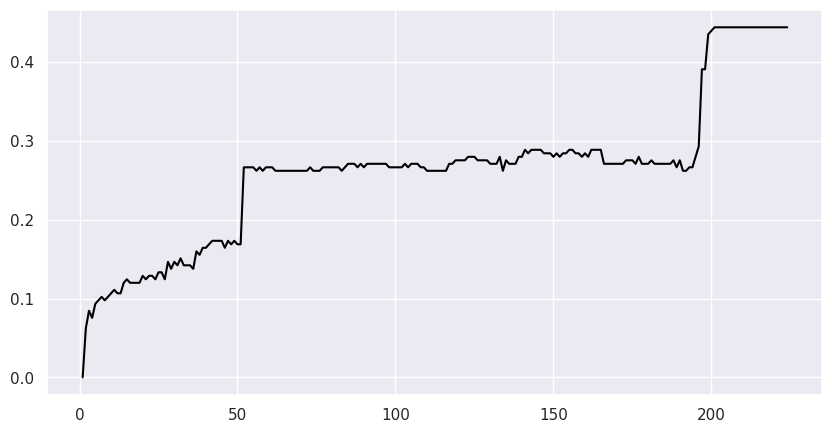

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(errors_and_ks["k"], errors_and_ks["Misclassification Rate"], color="black")

## Plot vs. Negative k

To make it look more like normal error vs. complexity  
Note note monotonic function, sometimes bumps back up  
Plot can't tell you what k to pick - if you take the min (k = 1), you would overfit

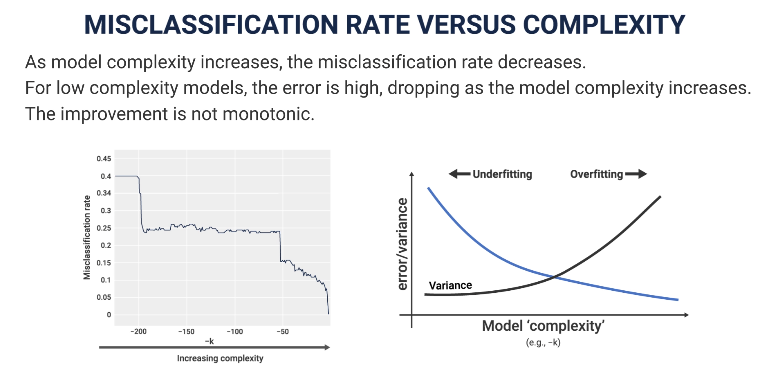

Text(0, 0.5, 'Misclassification Rate')

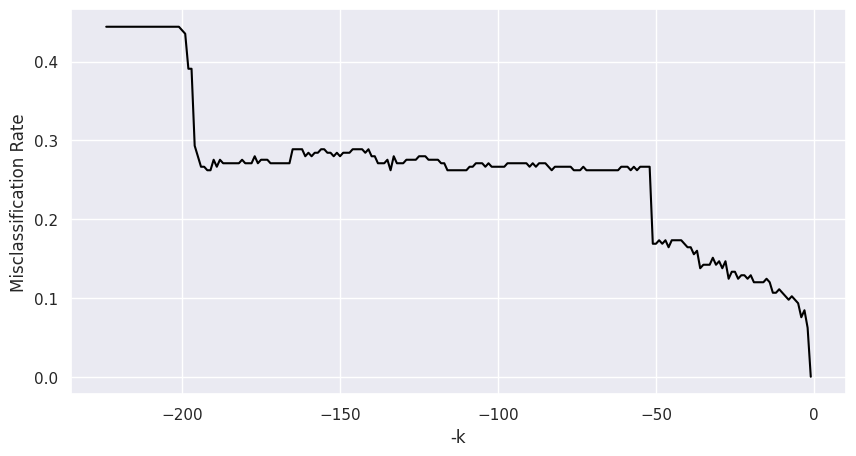

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(-errors_and_ks["k"], errors_and_ks["Misclassification Rate"], color="black")
plt.xlabel("-k")
plt.ylabel("Misclassification Rate")

## How to pick k?

Use cross validation, can once again use grid search cv and choose k to minimize validation error

In [15]:
X_train, X_dev, y_train, y_dev, inds_train, inds_dev = train_test_split(
    X, y, range(len(X)), random_state=42, test_size=0.25
)

### Do the grid search CV

Note using accuracy - maximize this

In [16]:
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid={"n_neighbors": ks},
    scoring="accuracy",
    cv=5,
).fit(X, y)

grid_search.best_params_

{'n_neighbors': 3}

In [17]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=3)

### Plot the Results

Notice there are some NaN's - the plot cuts off at ~180
- Because after that the range exceeds the size of the training from a kfold=5
- Max supported size for k = size of training set
- For kfolds 5 and this data set (length = 225), that would be 4/5*225 = 180

For the training errors, smaller the k, the better

On the cross-val set, k doesn't change error as much after ~150

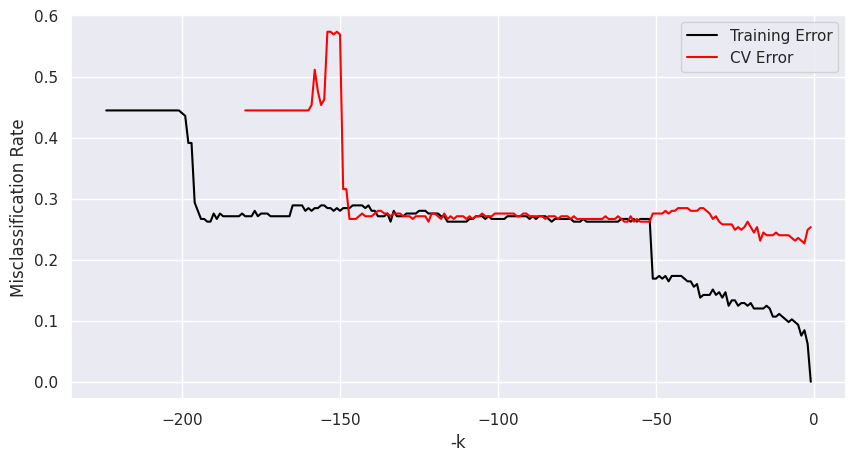

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(
    -errors_and_ks["k"],
    errors_and_ks["Misclassification Rate"],
    color="black",
    label="Training Error",
)
plt.plot(
    -errors_and_ks["k"],
    1.0 - grid_search.cv_results_["mean_test_score"],
    color="red",
    label="CV Error",
)
plt.xlabel("-k")
plt.ylabel("Misclassification Rate")
plt.legend()

Zoom in on small k, notice that magnitude of overfitting error is pretty small even at highest complexity (k = 1)

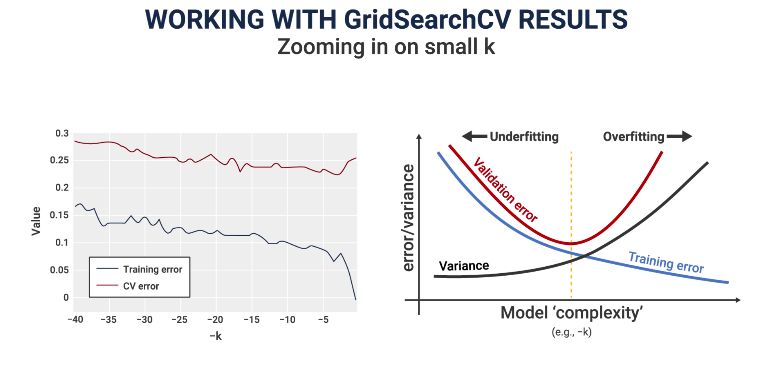

# 12.5 Prediction Probability and Decision Thresholds

In [19]:
df = pd.read_csv("./data/pay_status.csv")
X, y = df[["Income", "Debt"]], df["Status"]
model = KNeighborsClassifier(n_neighbors=10).fit(X, y)
random_rows = X.sample(10, random_state=42)
X.join(pd.DataFrame(model.predict(X), columns=["Prediction"]))

Income     Debt   Prediction
0    6552.53  1170.93  Did Not Pay
1    7247.80   570.94  Did Not Pay
2    8074.38   422.67         Paid
3    5776.60   872.42  Did Not Pay
4    6297.35   887.56  Did Not Pay
..       ...      ...          ...
220  1524.25  1071.41         Paid
221  2712.88  1261.57         Paid
222  2901.38  1228.07         Paid
223  1805.46  1214.41         Paid
224  2106.99  1133.36         Paid

[225 rows x 3 columns]

## How good is the model?

Introduce predict_proba
- Pity the name
- Predictions about a class
- And confidence level of model

Describing the output
- Rows are for samples
- Columns are for classes
- Column 1 = probability sample is in class 1
- Column 2 = probability sample is in class 2
- Column n = ...
- Ordering is alphabetical, e.g. if classes are {Paid, Did not Pay}
    - First column is Did not Pay
    - Second column is Paid

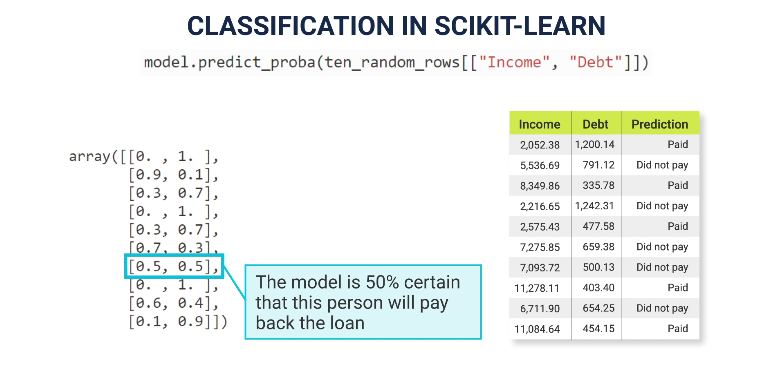

In [20]:
model.predict_proba(random_rows)

array([[1. , 0. ],
       [0.3, 0.7],
       [0. , 1. ],
       [0.2, 0.8],
       [0. , 1. ],
       [0. , 1. ],
       [0. , 1. ],
       [0.9, 0.1],
       [0. , 1. ],
       [0.4, 0.6]])

## Decision Threshold

Note that p = 0.5 is tie but goes to class 0

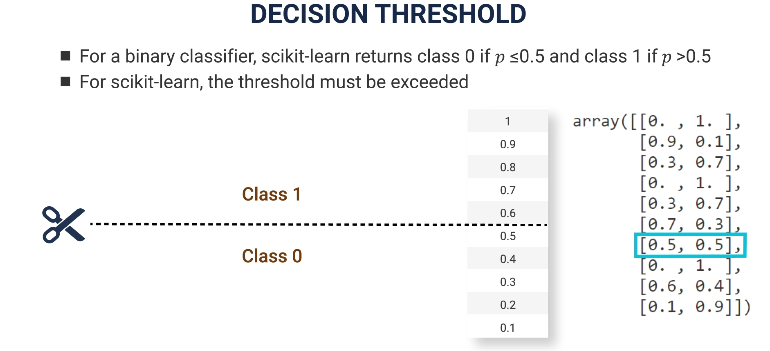

## Threshold is Settable

Example - set it to 0.8 instead of 0.5 default
- Consider a sample with a 30/70 proba result. Goes to Did not Pay because 70 < 80.
- Would still be Did not Pay with p = 0.7, because 70 not greater than 70 (i.e. must exceed, not meet, threshold)
- ties go to class 0

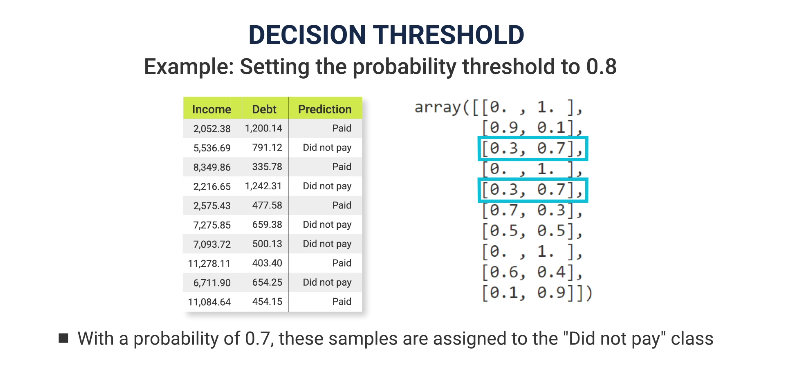

# Evaluating Classifiers

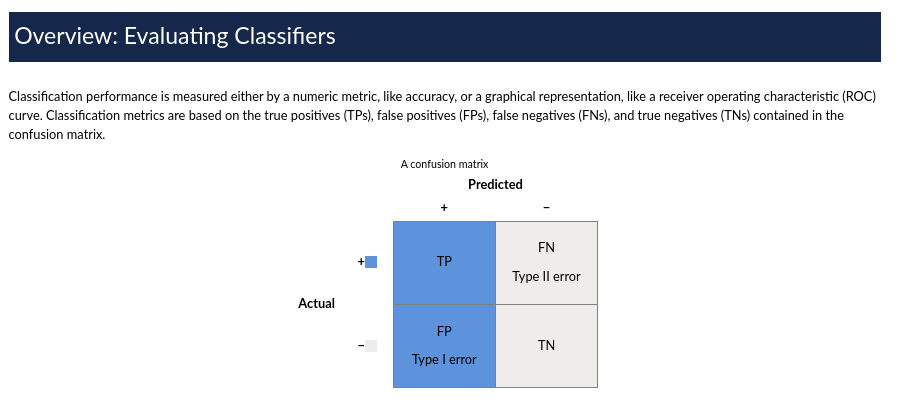

# 12.6 Classifier Metrics

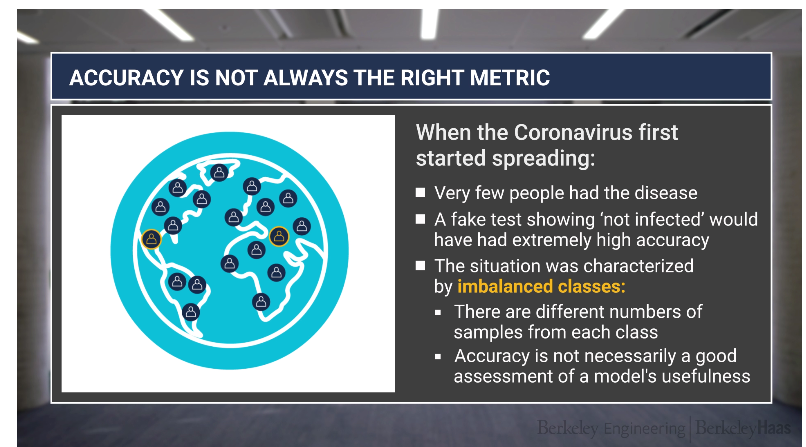

## Confusion Matrix

Useful even when classes are highly imbalanced
- Imbalanced means a high proportion of one class, e.g. out of 1 billion people, only 100,000 had covid.

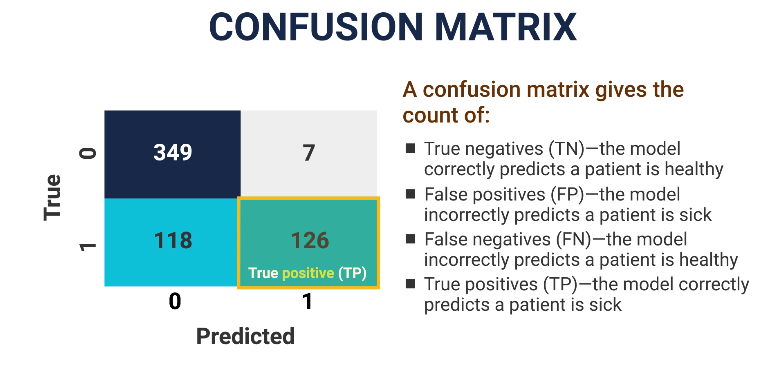

### Knowledge Check

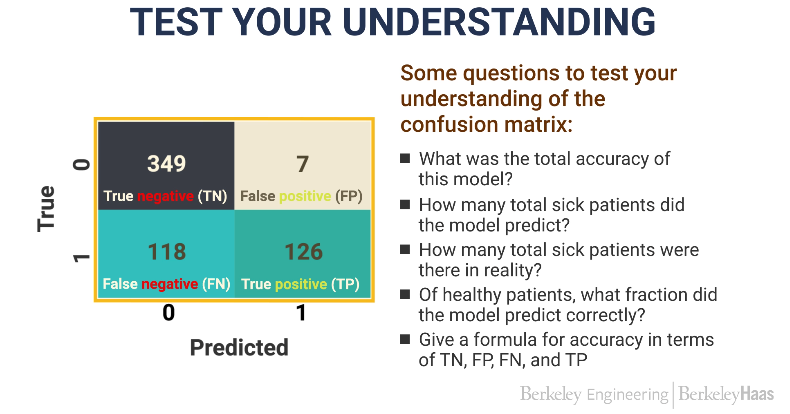

What is accuracy?  
num_correct / num_total

Terms, given that model prediction is "is patient sick"?
- Negative = not sick = healthy
- Positive = sick = not healthy

My Answers:
- Accuracy = (349 + 126) / (349 + 7 + 118 + 126) = 79%
- Total sick predicted = number of positives = FP + TP = 7 + 126
- Sick actual = FN + TP = 118 + 126
- Healthy actual = TN + FP = 349 + 7
- Fraction of healthy correct = TN / (TN + FP) = 349/356
- Accuracy = (TN + TP) / (TN + FP + FN + TP)

### Other Metrics Available from Terms of Confusion Matrix

Because it can be a little difficult to interpret directly, we have a bunch more confusing terms to struggle to intrepret instead

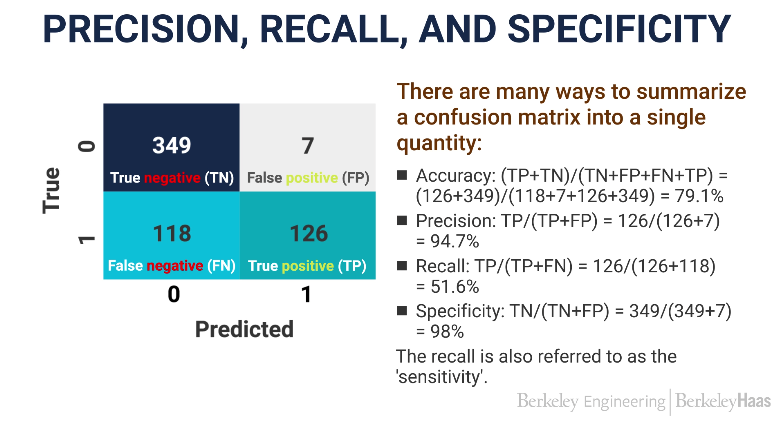

#### Precision

How many people who tested positive actually are positive (positive = has covid)?
- Num true positive / num total declared positive

#### Recall

Of those with covid, how many did model correctly predict?
- Remember to be truly positive, its TP + FN, because FN = false negative falsely declaring negative

#### Specificity

Of those without covid, how many did model correctly predict?

## Knowledge Check

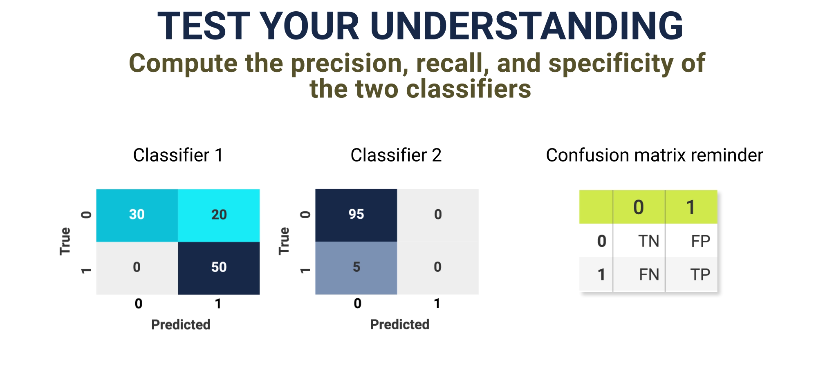

Precision: Tp/(Tp + Fp)  
Recall: Tp/(Tp + Fn)  
Specificity: Tn/(Tn + Fp)

Classifier 1  
TN = 30, FP = 20  
FN = 0, TP = 50  
P = 50/(50+20) = 71%  
R = 50/(50+0) = 100%  
S = 30/(30+20) = 60%  

Classifier 2  
TN = 95, FP = 0  
FN = 5, TP = 0  
P = 0/(0+0) = 0% or is it 100% or is it **undefined**?  
    - Answer: Undefined  
R = 0/(0+5) = 0%  
S = 95/(95+0) = 100%  

## Comparing Confusion Matrices / Metrics

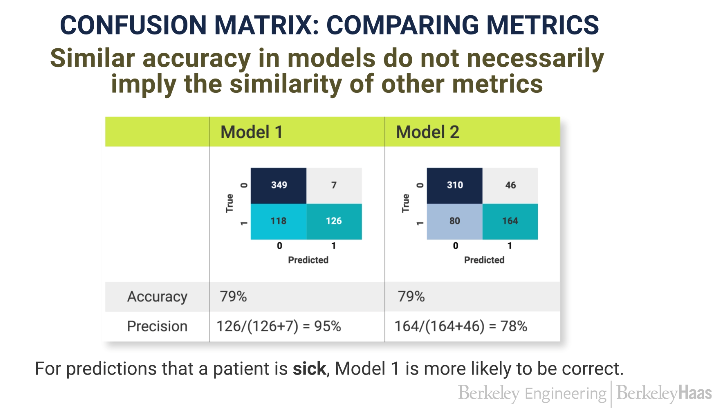

# Mini Lesson - Classifier Metrics on Context

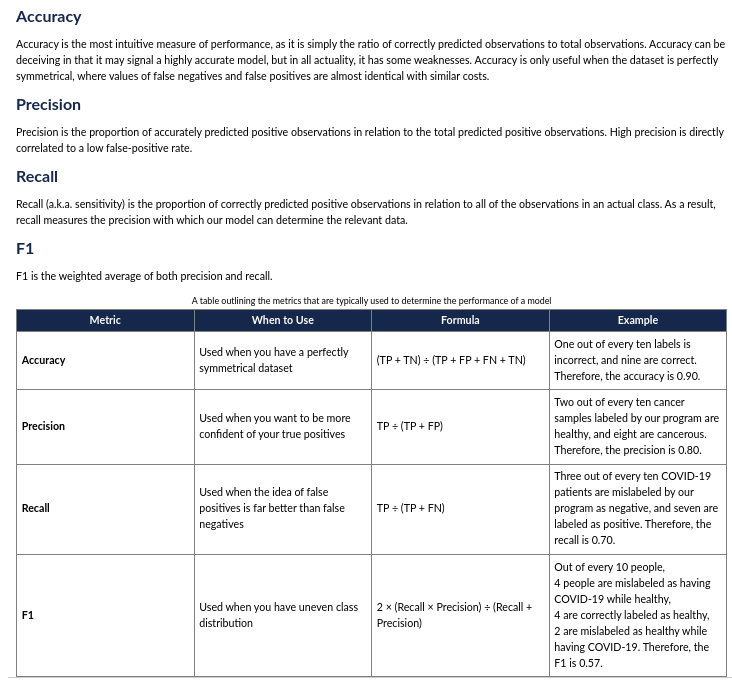

# Codio 12.4 What now?

0 = malignant = 1?

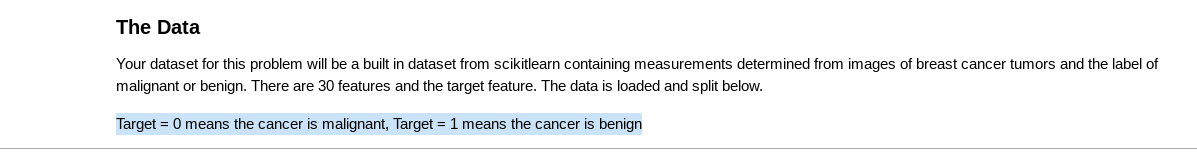

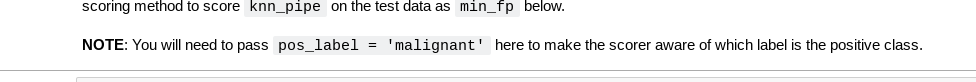

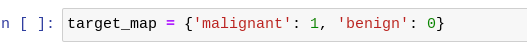

# 12.7 Choosing a Classifier Metric

Precision vs. recall
- High precision = we won't make many bad loans
- High recall = we're not missing good customers by misclassifying them as likely to default

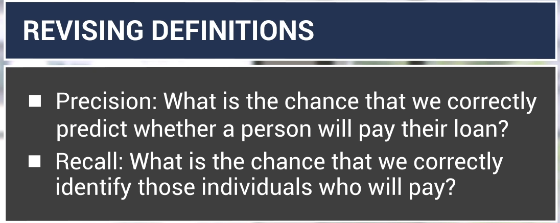

## Optimistic vs. Pessmistic Classifiers

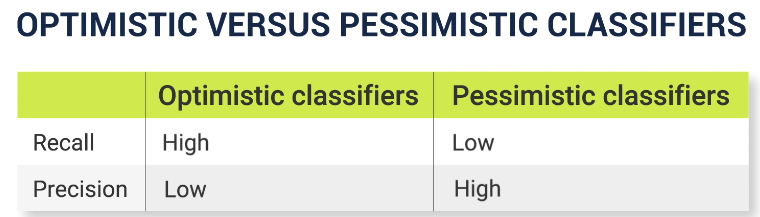

### Optimistic

Only classifies the very riskiest customers as part of default class

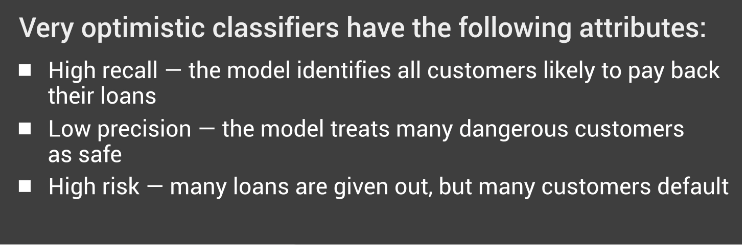

### Pessmistic

Only classifies the very safest customers as part of paid class

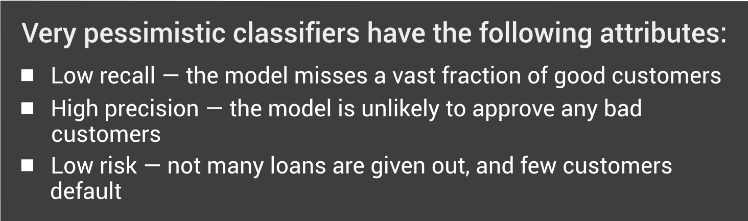

## Decision Thresholds

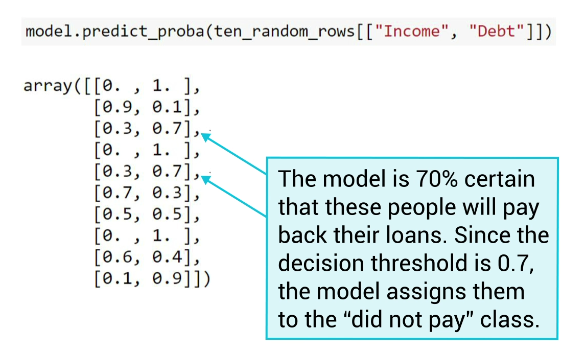

As decision treshold - t - increases
- fewer people pass the decision threshold
- more people are class 0 = do not pay
- model becomes more pessimistic
- precision goes up
- recall goes down, because we miss more and more good customers

## Precision / Recall Curve

In [21]:
X, y = df[["Income", "Debt"]], df["Status"]
model = KNeighborsClassifier(n_neighbors=10).fit(X, y)
yhat_proba = model.predict_proba(X)
precision, recall, thresholds = precision_recall_curve(
    y, yhat_proba[:, 1], pos_label="Paid"
)

Text(0, 0.5, 'Precision')

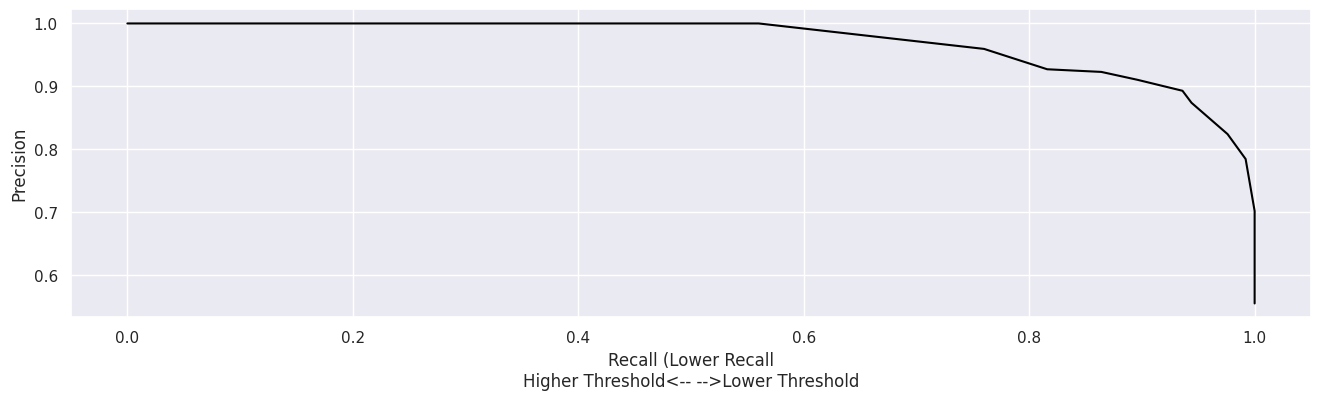

In [22]:
plt.plot(recall, precision, color="black")
plt.xlabel("Recall (Lower Recall\nHigher Threshold<-- -->Lower Threshold")
plt.ylabel("Precision")

### Uses of the Curve

You can use it to pick a treshold outright, and you can also use to compare 2 models, independent of the threshold.
- Consider the "no-skill model", one with no predictive skill at all
- Example, a random guesser

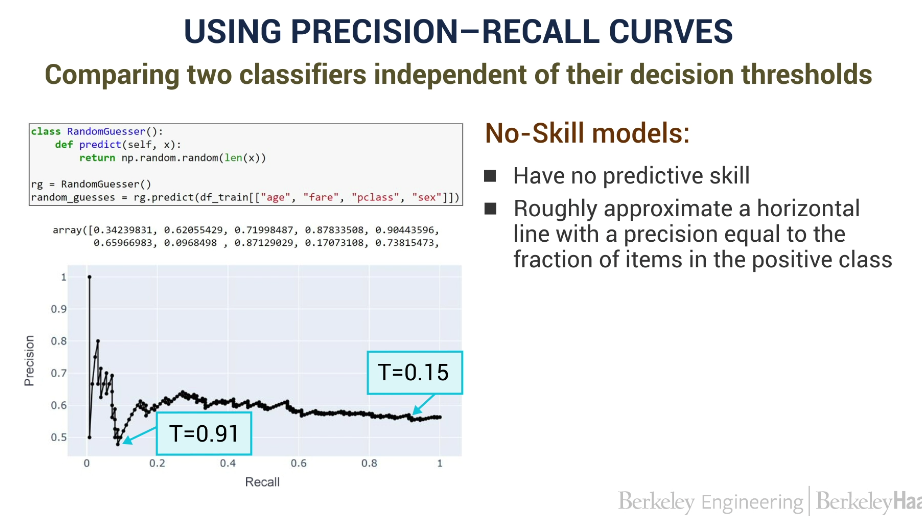

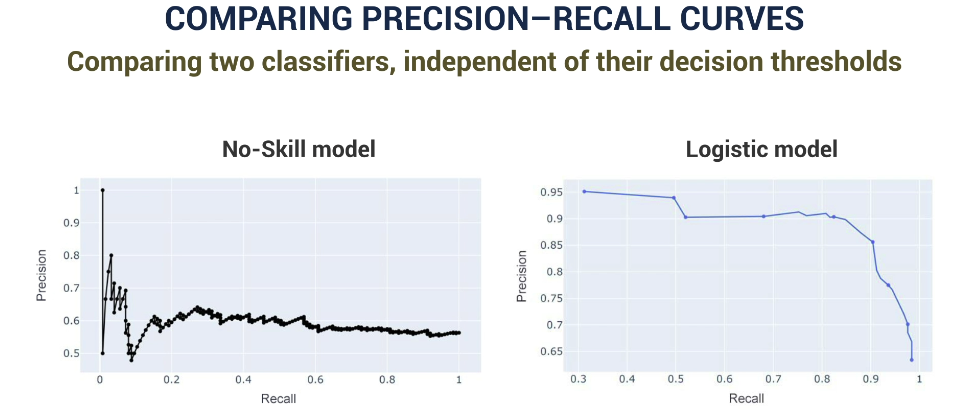

### Summarize a Curve By Integrating it (Area under Curve)

If you plot instead 1-specificity, you get the ROC curve receiver operating characterstic

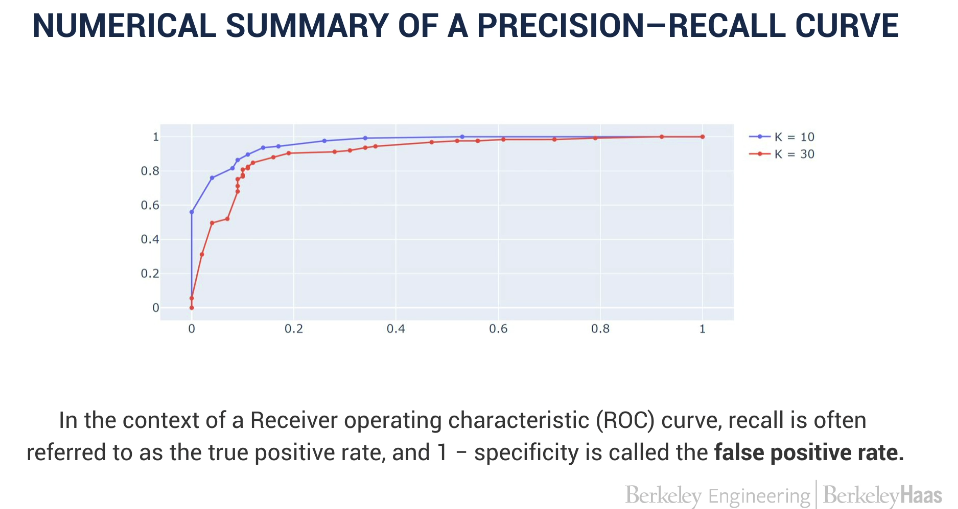

### Optimzing ROC Area under Curve (AUC) with Grid search

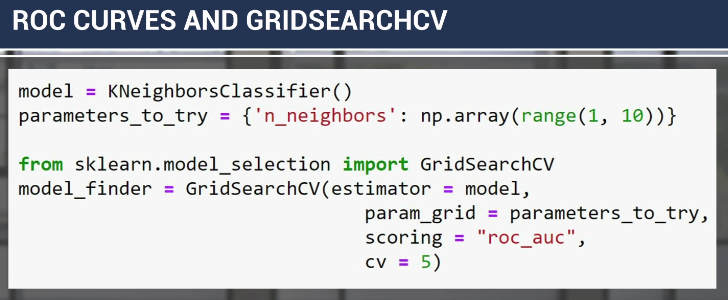

# 12.8 Regression with Nearest Neighbors

You can also do regression where the estimator is the nearest neighbor. Here you're not using NN as a classifier but as a regressor

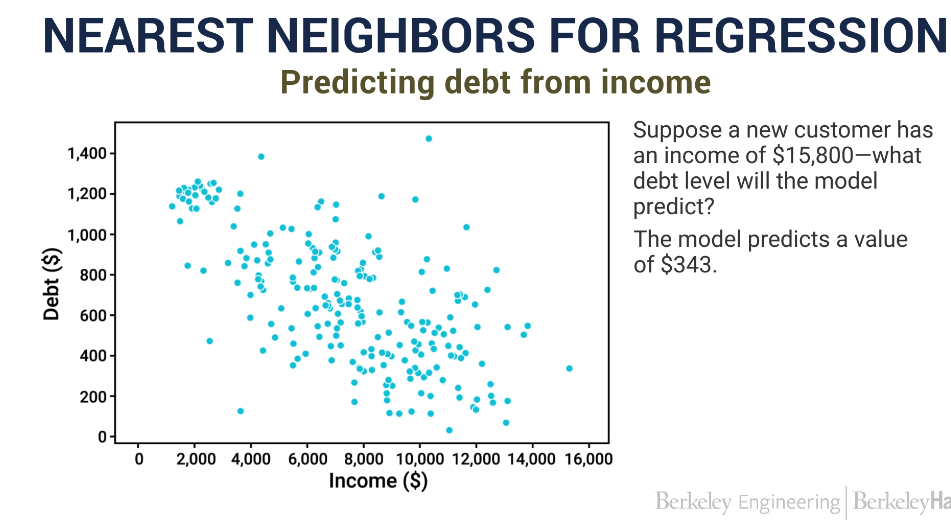

In [23]:
df = pd.read_csv("./data/pay_status.csv")
model = KNeighborsRegressor(n_neighbors=1).fit(df[["Income"]], df["Debt"])
model.predict([[15_800]])

array([343.56])

How does it work? Takes the average value from the K nearest neighbors.

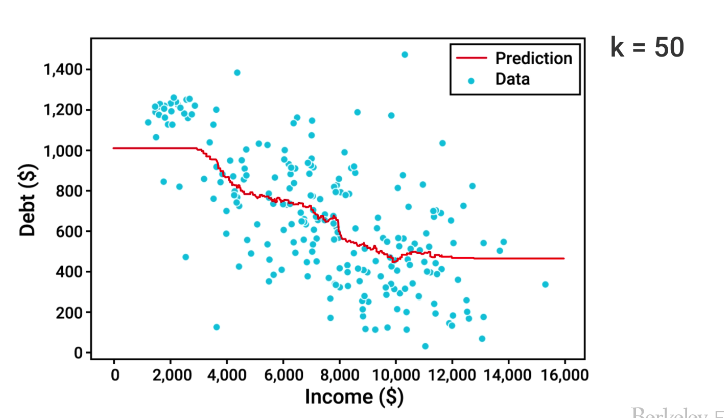

What K? Return to grid search and optimize whatever metric you want
- Because regression problem, probably choose MSE as loss function

# 12.9 Conclusion

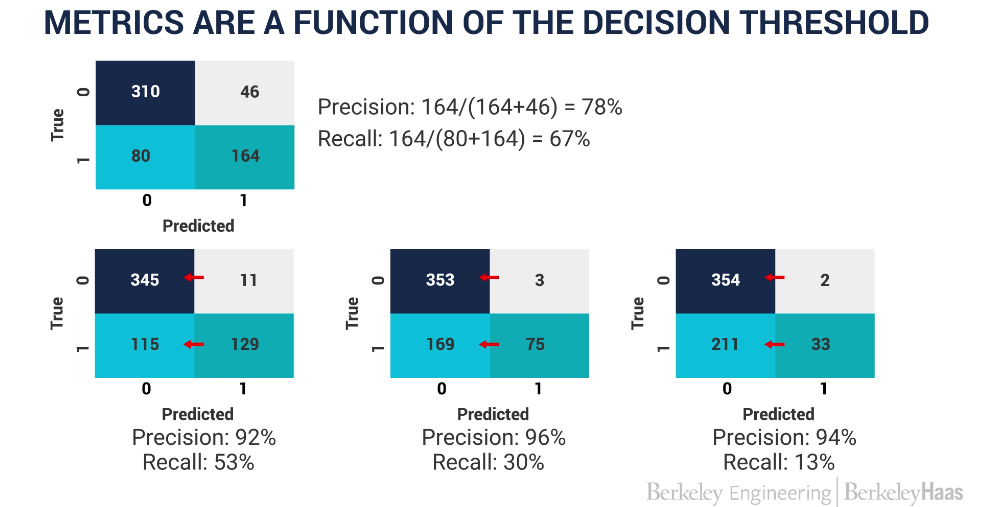

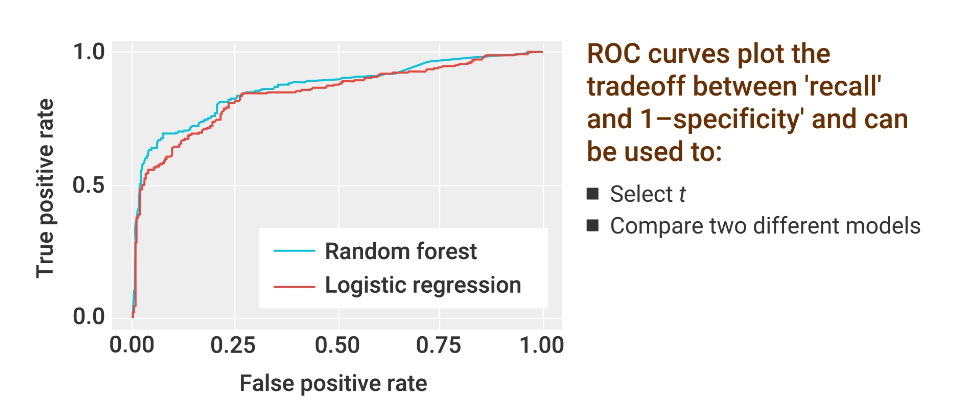

# Andres' Power Meter Data Plot

Data from here: https://archive.ics.uci.edu/dataset/422/wireless+indoor+localization

In [44]:
power_meter_names = ["Meter " + str(k + 1) for k in range(7)]

In [45]:
df = pd.read_csv(
    "./data/wifi_localization.txt",
    delim_whitespace=True,
    header=None,
    names=power_meter_names + ["Room"],
)
df

Meter 1  Meter 2  Meter 3  Meter 4  Meter 5  Meter 6  Meter 7  Room
0         -64      -56      -61      -66      -71      -82      -81     1
1         -68      -57      -61      -65      -71      -85      -85     1
2         -63      -60      -60      -67      -76      -85      -84     1
3         -61      -60      -68      -62      -77      -90      -80     1
4         -63      -65      -60      -63      -77      -81      -87     1
...       ...      ...      ...      ...      ...      ...      ...   ...
1995      -59      -59      -48      -66      -50      -86      -94     4
1996      -59      -56      -50      -62      -47      -87      -90     4
1997      -62      -59      -46      -65      -45      -87      -88     4
1998      -62      -58      -52      -61      -41      -90      -85     4
1999      -59      -50      -45      -60      -45      -88      -87     4

[2000 rows x 8 columns]

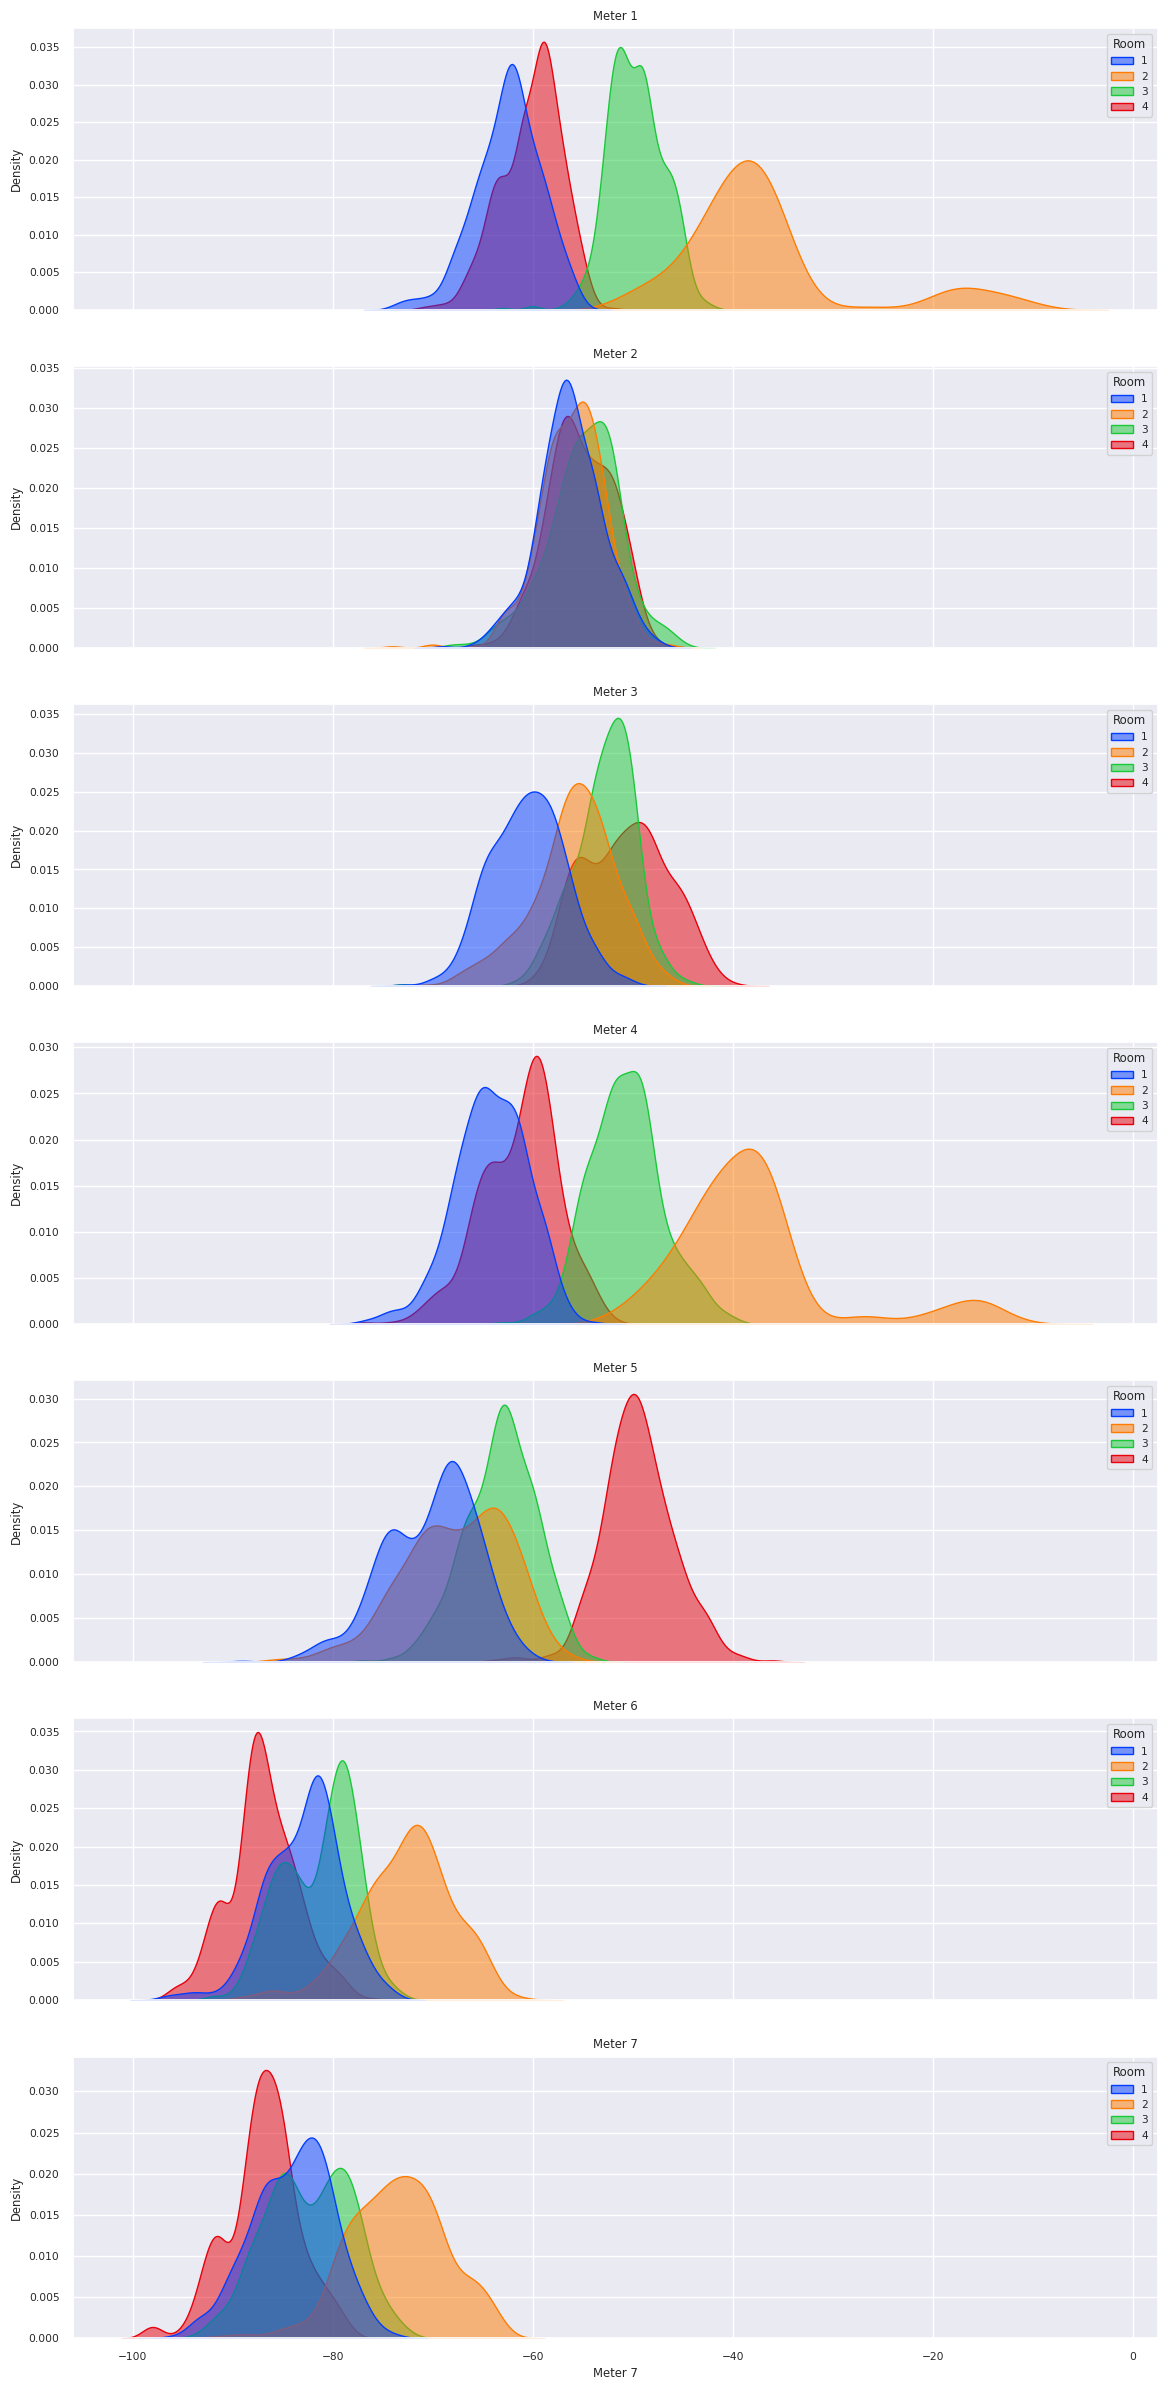

In [79]:
fig, ax = plt.subplots(nrows=len(power_meter_names), ncols=1, sharex=True)
fig.set_size_inches((14, 30))
sns.set(font_scale=0.7)

for k in range(len(power_meter_names)):
    sns.kdeplot(
        df,
        x=power_meter_names[k],
        fill=True,
        hue="Room",
        ax=ax[k],
        palette="bright",
        alpha=0.5,
        linewidth=1,
    )

    ax[k].set_title(power_meter_names[k])

In [64]:
df_melted = pd.melt(
    df,
    id_vars=["Room"],
    value_vars=power_meter_names,
    var_name="Meter",
    value_name="Power",
)
df_melted

Room    Meter  Power
0         1  Meter 1    -64
1         1  Meter 1    -68
2         1  Meter 1    -63
3         1  Meter 1    -61
4         1  Meter 1    -63
...     ...      ...    ...
13995     4  Meter 7    -94
13996     4  Meter 7    -90
13997     4  Meter 7    -88
13998     4  Meter 7    -85
13999     4  Meter 7    -87

[14000 rows x 3 columns]

In [69]:
rooms = list(df_melted["Room"].unique())
rooms

[1, 2, 3, 4]

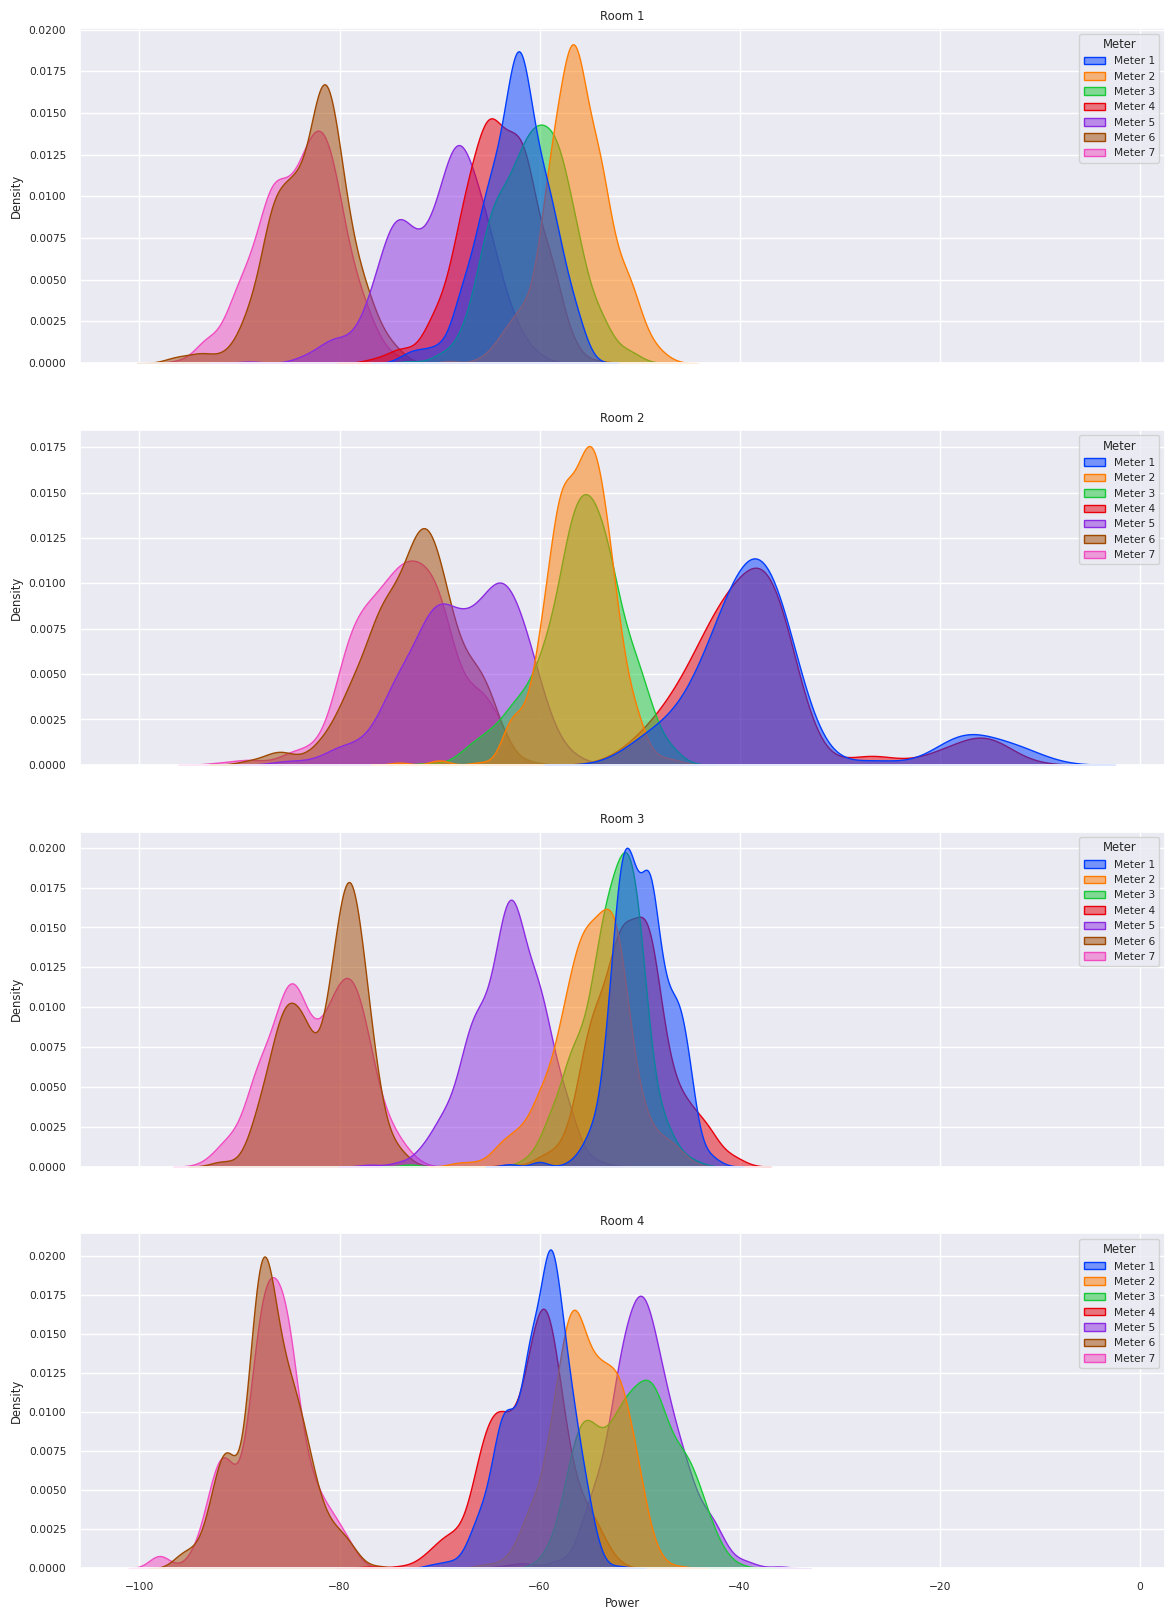

In [77]:
fig, ax = plt.subplots(nrows=len(rooms), ncols=1, sharex=True)
fig.set_size_inches((14, 20))
sns.set(font_scale=0.7)

for k in range(len(rooms)):
    room = rooms[k]
    sns.kdeplot(
        df_melted.query("Room == %d" % room),
        x="Power",
        fill=True,
        hue="Meter",
        ax=ax[k],
        palette="bright",
        alpha=0.5,
        linewidth=1,
    )

    ax[k].set_title("Room %d" % room)